In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
from training_utils import CIFAR10_dataloaders, training_monitor
import optuna

In [ ]:
#!pip install optuna

In [32]:
class DynamicMLP(nn.Module):
    def __init__(self, input_shape, hidden_sizes=[512, 256], output_size=10):
        super().__init__()
        # Compute input size dynamically
        input_dim = torch.prod(torch.tensor(input_shape)).item()
        
        # Construct layer sizes dynamically
        layer_sizes = [input_dim] + hidden_sizes + [output_size]

        # Create layers using nn.Sequential
        layers = []
        layers.append(nn.Flatten())
        for in_dim, out_dim in zip(layer_sizes[:-1], layer_sizes[1:]):
            layers.append(nn.Linear(in_dim, out_dim))
            if out_dim != output_size:  # Add ReLU except for the last layer
                layers.append(nn.ReLU())

        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

In [43]:
def objective(trial):
    # Suggest hyperparameters
    lr = trial.suggest_float("lr", 1e-4, 1e-1, log=True)
    batch_size = trial.suggest_int("batch_size", 32, 512, step=32)

    # Vary the number of hidden layers
    num_layers = trial.suggest_int("num_layers", 1, 5)  # Choose between 1 to 5 layers

    # Sample hidden layer sizes dynamically
    hidden_sizes = [
        trial.suggest_int(f"hidden_size_{i}", 64, 1024, step=64) for i in range(num_layers)
    ]

    # Define model dynamically
    model = DynamicMLP(input_shape=(3, 32, 32), hidden_sizes=hidden_sizes, output_size=10)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    # Training loop
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    trainloader, testloader, classes = CIFAR10_dataloaders(batch_size=batch_size)

    max_epochs = 10
    for epoch in range(max_epochs):
        model.train()
        for images, labels in trainloader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            output = model(images)
            loss = criterion(output, labels)
            loss.backward()
            optimizer.step()

        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in testloader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        accuracy = 100 * correct / total
        print(f"Epoch {epoch+1}/{max_epochs} - Accuracy: {accuracy}%")

        # Report intermediate accuracy for pruning
        trial.report(accuracy, epoch)

        # Prune if necessary
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()

    return accuracy

# Run optimization with TPE + Pruner
study = optuna.create_study(
    direction="maximize",
    sampler=optuna.samplers.TPESampler(),
    pruner=optuna.pruners.MedianPruner(n_startup_trials=1, n_warmup_steps=3, interval_steps=1),
)
study.optimize(objective, n_trials=20)

# Best hyperparameters
print("Best Hyperparameters:", study.best_params)

[I 2025-03-20 21:16:26,155] A new study created in memory with name: no-name-9843c47c-e257-470a-833f-946b31ea1893


Files already downloaded and verified
Files already downloaded and verified
Epoch 1/10 - Accuracy: 10.0%
Epoch 2/10 - Accuracy: 10.0%
Epoch 3/10 - Accuracy: 10.0%
Epoch 4/10 - Accuracy: 10.0%
Epoch 5/10 - Accuracy: 10.0%
Epoch 6/10 - Accuracy: 10.0%
Epoch 7/10 - Accuracy: 10.0%
Epoch 8/10 - Accuracy: 10.0%
Epoch 9/10 - Accuracy: 10.0%


[I 2025-03-20 21:17:14,387] Trial 0 finished with value: 10.0 and parameters: {'lr': 0.07196940064935556, 'batch_size': 256, 'num_layers': 4, 'hidden_size_0': 576, 'hidden_size_1': 448, 'hidden_size_2': 896, 'hidden_size_3': 384}. Best is trial 0 with value: 10.0.


Epoch 10/10 - Accuracy: 10.0%
Files already downloaded and verified
Files already downloaded and verified
Epoch 1/10 - Accuracy: 10.0%
Epoch 2/10 - Accuracy: 9.99%
Epoch 3/10 - Accuracy: 10.0%
Epoch 4/10 - Accuracy: 10.0%
Epoch 5/10 - Accuracy: 10.0%
Epoch 6/10 - Accuracy: 10.0%
Epoch 7/10 - Accuracy: 10.0%
Epoch 8/10 - Accuracy: 10.0%
Epoch 9/10 - Accuracy: 10.0%


[I 2025-03-20 21:18:03,884] Trial 1 finished with value: 10.0 and parameters: {'lr': 0.05796497035744556, 'batch_size': 128, 'num_layers': 3, 'hidden_size_0': 1024, 'hidden_size_1': 128, 'hidden_size_2': 384}. Best is trial 0 with value: 10.0.


Epoch 10/10 - Accuracy: 10.0%
Files already downloaded and verified
Files already downloaded and verified
Epoch 1/10 - Accuracy: 42.03%
Epoch 2/10 - Accuracy: 46.34%
Epoch 3/10 - Accuracy: 49.84%
Epoch 4/10 - Accuracy: 51.36%
Epoch 5/10 - Accuracy: 51.9%
Epoch 6/10 - Accuracy: 52.83%
Epoch 7/10 - Accuracy: 52.57%
Epoch 8/10 - Accuracy: 53.45%
Epoch 9/10 - Accuracy: 53.97%


[I 2025-03-20 21:18:52,479] Trial 2 finished with value: 51.14 and parameters: {'lr': 0.00015834082466158463, 'batch_size': 352, 'num_layers': 5, 'hidden_size_0': 1024, 'hidden_size_1': 64, 'hidden_size_2': 896, 'hidden_size_3': 640, 'hidden_size_4': 960}. Best is trial 2 with value: 51.14.


Epoch 10/10 - Accuracy: 51.14%
Files already downloaded and verified
Files already downloaded and verified
Epoch 1/10 - Accuracy: 36.39%
Epoch 2/10 - Accuracy: 40.92%
Epoch 3/10 - Accuracy: 42.68%
Epoch 4/10 - Accuracy: 45.47%
Epoch 5/10 - Accuracy: 49.06%
Epoch 6/10 - Accuracy: 48.83%
Epoch 7/10 - Accuracy: 49.14%
Epoch 8/10 - Accuracy: 49.97%
Epoch 9/10 - Accuracy: 50.73%


[I 2025-03-20 21:19:55,191] Trial 3 finished with value: 51.11 and parameters: {'lr': 0.002370735690187345, 'batch_size': 32, 'num_layers': 5, 'hidden_size_0': 832, 'hidden_size_1': 1024, 'hidden_size_2': 192, 'hidden_size_3': 896, 'hidden_size_4': 1024}. Best is trial 2 with value: 51.14.


Epoch 10/10 - Accuracy: 51.11%
Files already downloaded and verified
Files already downloaded and verified
Epoch 1/10 - Accuracy: 45.59%
Epoch 2/10 - Accuracy: 48.28%
Epoch 3/10 - Accuracy: 49.61%
Epoch 4/10 - Accuracy: 51.41%
Epoch 5/10 - Accuracy: 51.24%
Epoch 6/10 - Accuracy: 52.3%
Epoch 7/10 - Accuracy: 52.11%
Epoch 8/10 - Accuracy: 53.0%
Epoch 9/10 - Accuracy: 53.22%


[I 2025-03-20 21:20:42,796] Trial 4 finished with value: 53.44 and parameters: {'lr': 0.0004944755208722987, 'batch_size': 512, 'num_layers': 1, 'hidden_size_0': 320}. Best is trial 4 with value: 53.44.


Epoch 10/10 - Accuracy: 53.44%
Files already downloaded and verified
Files already downloaded and verified
Epoch 1/10 - Accuracy: 45.43%
Epoch 2/10 - Accuracy: 50.11%
Epoch 3/10 - Accuracy: 51.33%
Epoch 4/10 - Accuracy: 53.32%
Epoch 5/10 - Accuracy: 53.74%
Epoch 6/10 - Accuracy: 54.55%
Epoch 7/10 - Accuracy: 53.97%
Epoch 8/10 - Accuracy: 53.74%
Epoch 9/10 - Accuracy: 54.65%


[I 2025-03-20 21:21:31,078] Trial 5 finished with value: 55.39 and parameters: {'lr': 0.0005015375480590007, 'batch_size': 320, 'num_layers': 4, 'hidden_size_0': 448, 'hidden_size_1': 832, 'hidden_size_2': 256, 'hidden_size_3': 640}. Best is trial 5 with value: 55.39.


Epoch 10/10 - Accuracy: 55.39%
Files already downloaded and verified
Files already downloaded and verified
Epoch 1/10 - Accuracy: 45.03%
Epoch 2/10 - Accuracy: 47.3%
Epoch 3/10 - Accuracy: 47.36%
Epoch 4/10 - Accuracy: 49.44%


[I 2025-03-20 21:21:56,965] Trial 6 pruned. 


Epoch 5/10 - Accuracy: 48.29%
Files already downloaded and verified
Files already downloaded and verified
Epoch 1/10 - Accuracy: 42.55%
Epoch 2/10 - Accuracy: 44.48%
Epoch 3/10 - Accuracy: 45.41%
Epoch 4/10 - Accuracy: 49.02%


[I 2025-03-20 21:22:21,497] Trial 7 pruned. 


Epoch 5/10 - Accuracy: 47.03%
Files already downloaded and verified
Files already downloaded and verified
Epoch 1/10 - Accuracy: 46.7%
Epoch 2/10 - Accuracy: 49.22%
Epoch 3/10 - Accuracy: 51.23%
Epoch 4/10 - Accuracy: 52.18%
Epoch 5/10 - Accuracy: 52.27%
Epoch 6/10 - Accuracy: 53.15%
Epoch 7/10 - Accuracy: 53.12%
Epoch 8/10 - Accuracy: 52.88%
Epoch 9/10 - Accuracy: 52.81%


[I 2025-03-20 21:23:23,749] Trial 8 finished with value: 53.9 and parameters: {'lr': 0.00016592620910738088, 'batch_size': 32, 'num_layers': 4, 'hidden_size_0': 128, 'hidden_size_1': 64, 'hidden_size_2': 256, 'hidden_size_3': 768}. Best is trial 5 with value: 55.39.


Epoch 10/10 - Accuracy: 53.9%
Files already downloaded and verified
Files already downloaded and verified
Epoch 1/10 - Accuracy: 42.13%
Epoch 2/10 - Accuracy: 46.51%
Epoch 3/10 - Accuracy: 48.33%


[I 2025-03-20 21:23:44,188] Trial 9 pruned. 


Epoch 4/10 - Accuracy: 50.14%
Files already downloaded and verified
Files already downloaded and verified
Epoch 1/10 - Accuracy: 28.24%
Epoch 2/10 - Accuracy: 32.89%
Epoch 3/10 - Accuracy: 39.26%


[I 2025-03-20 21:24:04,148] Trial 10 pruned. 


Epoch 4/10 - Accuracy: 39.55%
Files already downloaded and verified
Files already downloaded and verified
Epoch 1/10 - Accuracy: 44.26%
Epoch 2/10 - Accuracy: 48.19%
Epoch 3/10 - Accuracy: 49.61%


[I 2025-03-20 21:24:24,141] Trial 11 pruned. 


Epoch 4/10 - Accuracy: 50.23%
Files already downloaded and verified
Files already downloaded and verified
Epoch 1/10 - Accuracy: 46.16%
Epoch 2/10 - Accuracy: 49.18%
Epoch 3/10 - Accuracy: 51.59%
Epoch 4/10 - Accuracy: 53.27%
Epoch 5/10 - Accuracy: 53.75%
Epoch 6/10 - Accuracy: 54.06%
Epoch 7/10 - Accuracy: 54.46%
Epoch 8/10 - Accuracy: 54.61%
Epoch 9/10 - Accuracy: 54.44%


[I 2025-03-20 21:25:12,617] Trial 12 finished with value: 54.64 and parameters: {'lr': 0.0004051254760860046, 'batch_size': 256, 'num_layers': 3, 'hidden_size_0': 256, 'hidden_size_1': 640, 'hidden_size_2': 320}. Best is trial 5 with value: 55.39.


Epoch 10/10 - Accuracy: 54.64%
Files already downloaded and verified
Files already downloaded and verified
Epoch 1/10 - Accuracy: 46.31%
Epoch 2/10 - Accuracy: 51.28%
Epoch 3/10 - Accuracy: 52.64%
Epoch 4/10 - Accuracy: 52.57%
Epoch 5/10 - Accuracy: 53.98%
Epoch 6/10 - Accuracy: 54.39%
Epoch 7/10 - Accuracy: 54.84%
Epoch 8/10 - Accuracy: 54.57%
Epoch 9/10 - Accuracy: 54.7%


[I 2025-03-20 21:26:01,165] Trial 13 finished with value: 55.33 and parameters: {'lr': 0.0006118981811937671, 'batch_size': 256, 'num_layers': 3, 'hidden_size_0': 256, 'hidden_size_1': 704, 'hidden_size_2': 576}. Best is trial 5 with value: 55.39.


Epoch 10/10 - Accuracy: 55.33%
Files already downloaded and verified
Files already downloaded and verified
Epoch 1/10 - Accuracy: 47.61%
Epoch 2/10 - Accuracy: 49.65%
Epoch 3/10 - Accuracy: 52.74%
Epoch 4/10 - Accuracy: 53.36%
Epoch 5/10 - Accuracy: 54.74%
Epoch 6/10 - Accuracy: 54.41%
Epoch 7/10 - Accuracy: 54.94%
Epoch 8/10 - Accuracy: 55.26%
Epoch 9/10 - Accuracy: 54.36%


[I 2025-03-20 21:26:49,327] Trial 14 finished with value: 55.19 and parameters: {'lr': 0.0011766373407648457, 'batch_size': 416, 'num_layers': 2, 'hidden_size_0': 512, 'hidden_size_1': 704}. Best is trial 5 with value: 55.39.


Epoch 10/10 - Accuracy: 55.19%
Files already downloaded and verified
Files already downloaded and verified
Epoch 1/10 - Accuracy: 40.59%
Epoch 2/10 - Accuracy: 44.58%
Epoch 3/10 - Accuracy: 46.98%


[W 2025-03-20 21:27:08,370] Trial 15 failed with parameters: {'lr': 0.004909391795974472, 'batch_size': 192, 'num_layers': 2, 'hidden_size_0': 640, 'hidden_size_1': 896} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/hetghome/antonpr/miniconda3/envs/ml_p311/lib/python3.11/site-packages/optuna/study/_optimize.py", line 197, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "/tmp/ipykernel_4012045/3278609817.py", line 36, in objective
    for images, labels in trainloader:
  File "/hetghome/antonpr/miniconda3/envs/ml_p311/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 630, in __next__
    data = self._next_data()
           ^^^^^^^^^^^^^^^^^
  File "/hetghome/antonpr/miniconda3/envs/ml_p311/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 673, in _next_data
    data = self._dataset_fetcher.fetch(index)  # may raise StopIteration
           ^^^^^^^^^^^^^^^^^^^^^^^

KeyboardInterrupt: 

Files already downloaded and verified
Files already downloaded and verified


  0%|          | 0/30 [00:00<?, ?it/s]

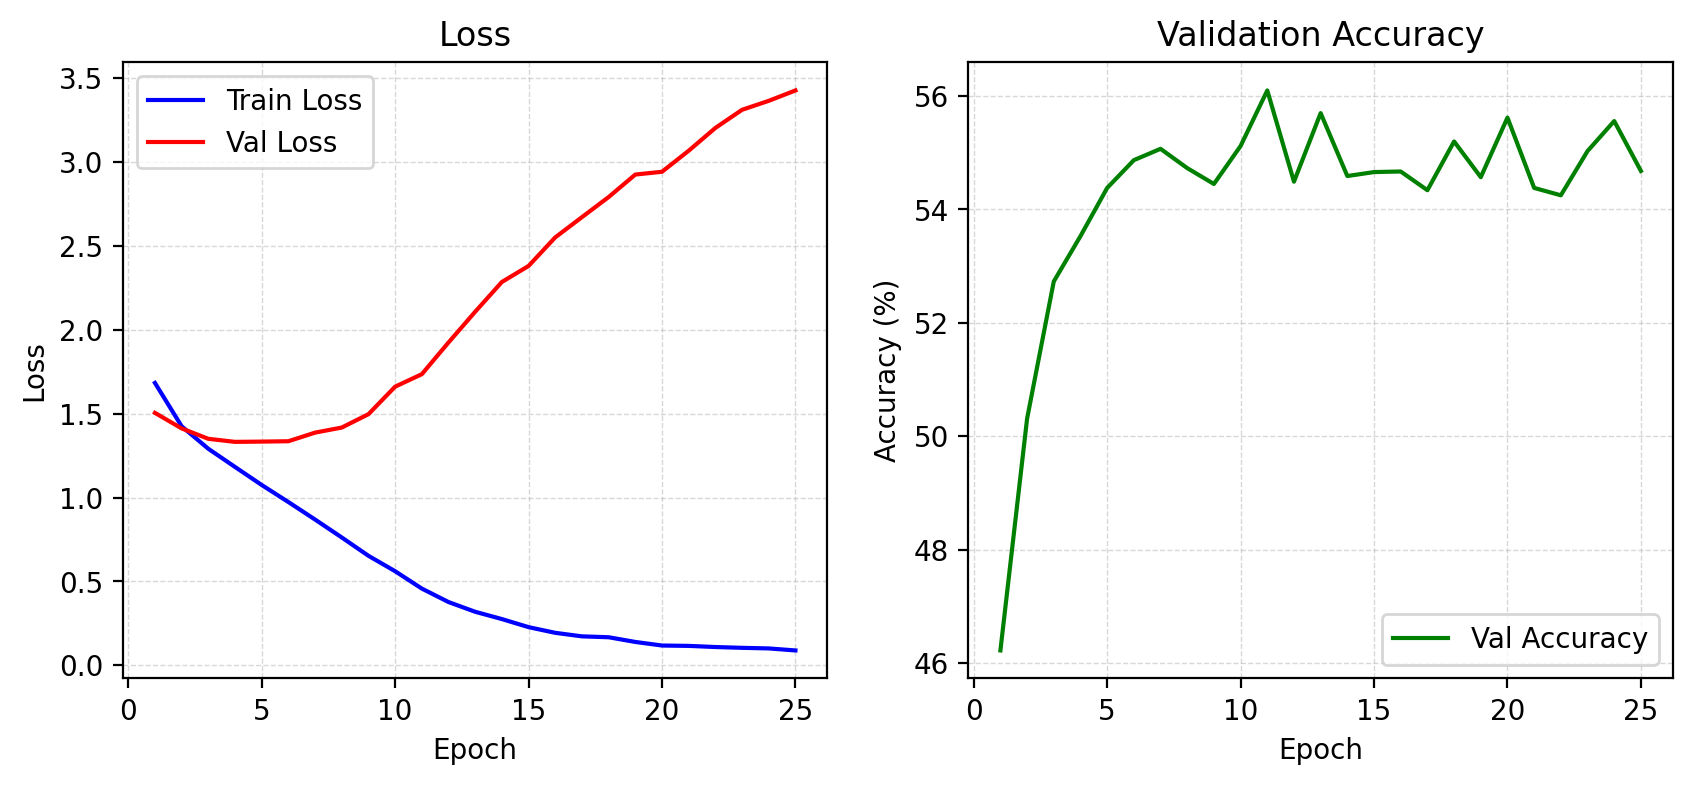

Epoch 25/30:  83%|########3 | 25/30 [02:07<00:25,  5.07s/it]

|       Epoch        |     Train loss     |  Validation loss   | Validation accuracy, %  |
__________________________________________________________________________________________
|         1          |       1.6832       |       1.5047       |         46.2200         |
|         2          |       1.4247       |       1.4120       |         50.3100         |
|         3          |       1.2906       |       1.3500       |         52.7300         |
|         4          |       1.1823       |       1.3318       |         53.5300         |
|         5          |       1.0748       |       1.3335       |         54.3800         |
|         6          |       0.9731       |       1.3356       |         54.8700         |
|         7          |       0.8687       |       1.3870       |         55.0700         |
|         8          |       0.7619       |       1.4173       |         54.7300         |
|         9          |       0.6527       |       1.4968       |         54.4500         |

KeyboardInterrupt: 

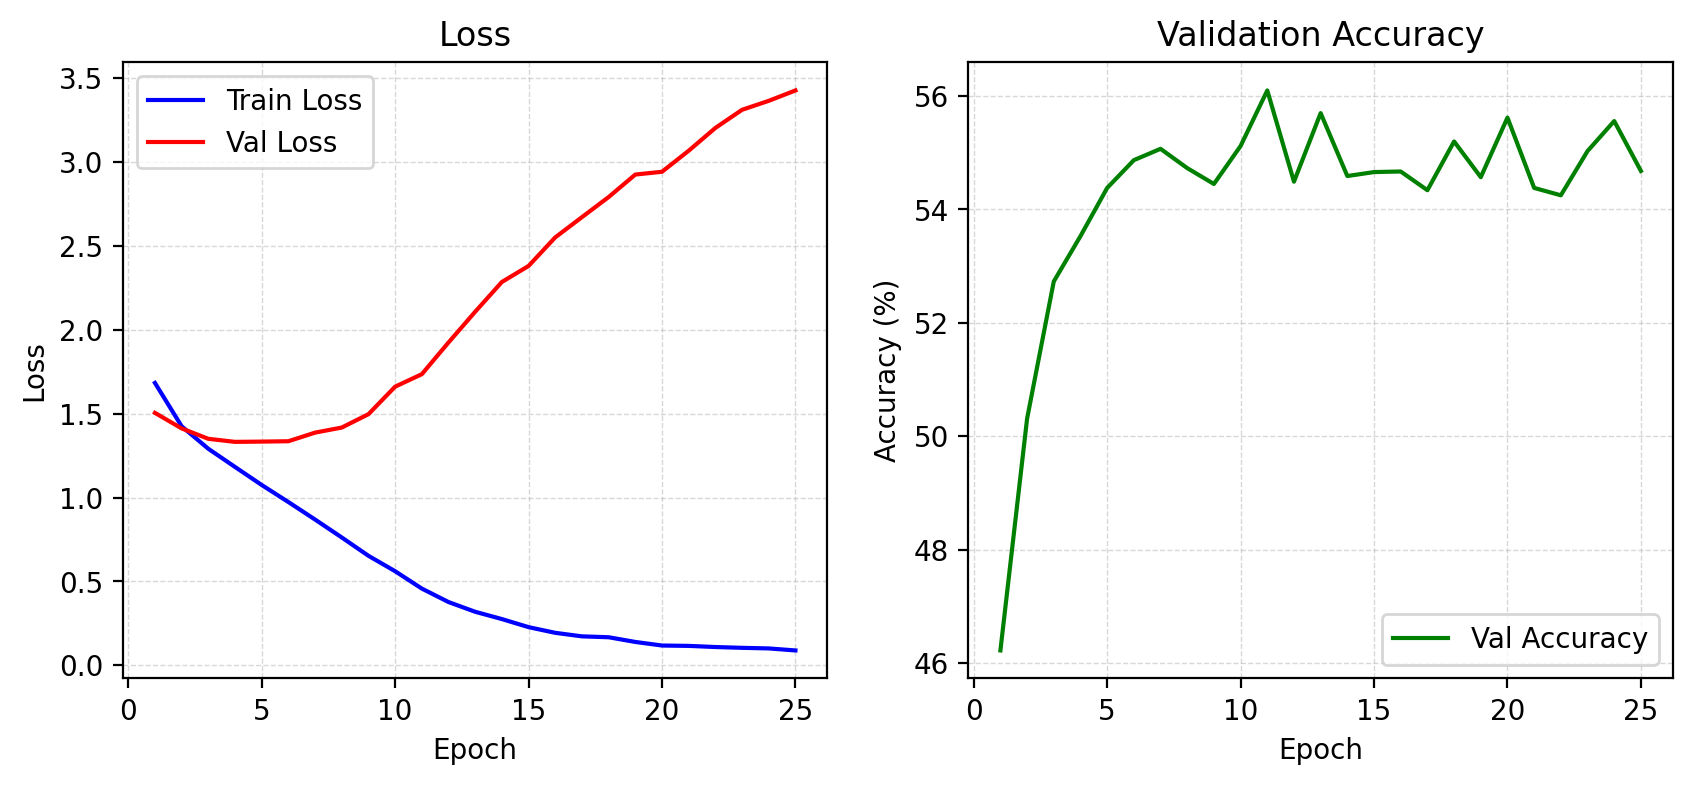

In [46]:
trainloader, testloader, classes = CIFAR10_dataloaders(batch_size=512)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model =   DynamicMLP((32, 32, 3), [704, 832, 1024], 10).to(device) 
# model = SimpleMLP(nmax=864).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0009776774809513965)
num_epochs = 30

trained_model = training_monitor(device, model, optimizer, criterion, num_epochs, trainloader, testloader)